Epoch 1/100
1454/1454 - 13s - loss: 0.0033 - 13s/epoch - 9ms/step
Epoch 2/100
1454/1454 - 7s - loss: 3.2141e-04 - 7s/epoch - 5ms/step
Epoch 3/100
1454/1454 - 6s - loss: 3.1677e-04 - 6s/epoch - 4ms/step
Epoch 4/100
1454/1454 - 4s - loss: 2.9360e-04 - 4s/epoch - 3ms/step
Epoch 5/100
1454/1454 - 3s - loss: 2.6276e-04 - 3s/epoch - 2ms/step
Epoch 6/100
1454/1454 - 6s - loss: 2.2399e-04 - 6s/epoch - 4ms/step
Epoch 7/100
1454/1454 - 4s - loss: 2.1698e-04 - 4s/epoch - 3ms/step
Epoch 8/100
1454/1454 - 7s - loss: 1.8359e-04 - 7s/epoch - 5ms/step
Epoch 9/100
1454/1454 - 3s - loss: 1.6709e-04 - 3s/epoch - 2ms/step
Epoch 10/100
1454/1454 - 6s - loss: 1.5313e-04 - 6s/epoch - 4ms/step
Epoch 11/100
1454/1454 - 3s - loss: 1.4293e-04 - 3s/epoch - 2ms/step
Epoch 12/100
1454/1454 - 7s - loss: 1.4532e-04 - 7s/epoch - 4ms/step
Epoch 13/100
1454/1454 - 4s - loss: 1.4309e-04 - 4s/epoch - 3ms/step
Epoch 14/100
1454/1454 - 7s - loss: 1.3786e-04 - 7s/epoch - 5ms/step
Epoch 15/100
1454/1454 - 4s - loss: 1.3617e-0

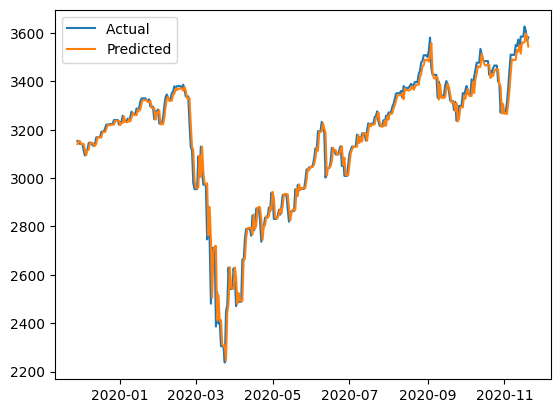

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv('stock_prices.csv')
dates = pd.to_datetime(data['Date'])  # convert dates to pandas datetime object

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split data
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,
                                    :], data_scaled[train_size:len(data_scaled), :]
train_dates, test_dates = dates[0:train_size], dates[train_size:len(dates)]

# Create X and Y for training and testing sets


def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)


time_steps = 5  # number of previous time steps to use as input variables to predict the next time period
X_train, Y_train = create_dataset(train_data, time_steps) # create training set
X_test, Y_test = create_dataset(test_data, time_steps) # create testing set

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 1))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam') 

# Train LSTM model
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# Evaluate LSTM model
train_score = model.evaluate(X_train, Y_train, verbose=0)
test_score = model.evaluate(X_test, Y_test, verbose=0)

print('Train Score: %.2f MSE (%.2f RMSE)' %
      (train_score, np.sqrt(train_score)))
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, np.sqrt(test_score)))

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Plot predictions vs actual values

plt.plot(test_dates[time_steps+1:len(test_data)+1], Y_test[0], label='Actual ')
plt.plot(test_dates[time_steps+1:len(test_data)+1],
         test_predict[:, 0], label='Predicted')
plt.legend()
plt.show()
